In [14]:
# !pip install matplotlib pandas

In [1]:
from typing import List, Dict, Tuple

import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

__WORKING_BRANCH_PATH = (
    "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch"
)

hatch = {
    'Vector': '',
    'Skiplist': '\\\\\\\\\\\\',
    'Hashskiplist': '//',
    'Hashlinklist': '----'
}

linestyle = {
    'Vector': '-',
    'Skiplist': '-',
    'Hashskiplist': '-.',
    'Hashlinklist': '..'
}

alpha = {
    'Vector': 1,
    'Skiplist': 0.6,
    'Hashskiplist': 1,
    'Hashlinklist': 0.8
}

color = {
    # 'Vector': 'darkslateblue',
    # 'Skiplist': 'olive',
    # 'Hashskiplist': 'darkred',
    # 'Hashlinklist': 'steelblue'
    # 'Vector': 'black',
    # 'Skiplist': 'black',
    # 'Hashskiplist': 'black',
    # 'Hashlinklist': 'black'
}

edgecolor = {
    'Vector': 'black',
    'Skiplist': 'black',
    'Hashskiplist': 'black',
    'Hashlinklist': 'black'
}

label = {
    'Vector': 'vector',
    'Skiplist': 'skiplist',
    'Hashskiplist': 'hash skiplist',
    'Hashlinklist': 'hash linklist'
}

plt.rcParams["font.family"] = "serif"

alphabets = "abcdefghijklmnopqrstuvwxyz"

def get_properties(key: str) -> Dict[str, str]:
    if key.capitalize() in label:
        return {
            # "label": label.get(key.capitalize()),
            "color": color.get(key.capitalize()) or "None",
            "edgecolor": edgecolor.get(key.capitalize()) or "None",
            # "linestyle": linestyle.get(key.capitalize()),
            "hatch": hatch.get(key.capitalize()),
            "alpha": alpha.get(key.capitalize()),
        }
    else:
        raise ValueError(f"Unknown key: {key}")


In [130]:
CWD = Path(os.getcwd())

log_file = 'workload.log'
flush_stats_file = 'flush_stats.csv'
compaction_stats_file = 'compaction_stats.csv'
inserts_stats_file = 'insert_stats.csv'
pq_stats_file = 'pq_stats.csv'

FIGSIZE = (32, 24)

# plt.style.use('seaborn-v0_8-darkgrid')

In [131]:
def split_by_eq_pull_time(string):
    tmp = string.split(' = ')[1]
    return float(tmp.split(' ')[0])

def get_times_for(log_file, key="InsertTime: "):

    result_list = list()

    for line in open(log_file, 'r').readlines():
        if line.startswith(key):
            result_list.append(int(line.split(' ')[1]))

    return result_list

def get_timess(file):
    exec_time = {
        "AvgInsertTime": 0,
        "AvgPointQueryTime": 0,
        "AvgRangeQueryTime": 0
    }
            
    insert_times = get_times_for(file, key="InsertTime: ")
    pq_times = get_times_for(file, key="PointQueryTime: ")
    rq_times = get_times_for(file, key="RangeQueryTime: ")
            
    exec_time["AvgInsertTime"] = np.mean(insert_times)
    exec_time["AvgPointQueryTime"] = np.mean(pq_times)
    exec_time["AvgRangeQueryTime"] = np.mean(rq_times)
            
    return exec_time


# def get_times(lines):
#     """ Get workload exection Time """

#     exection_times = {
#         'workloadTime': 0,
#         'insertsTime': 0,
#         'queriesTime': 0,
#         'updatesTime': 0,
#         'deletesTime': 0,
#         'rangeQueriesTime': 0
#     }

#     for line in lines:
#         if line.startswith('Total time taken by workload'):
#             exection_times['workloadTime'] = split_by_eq_pull_time(line)
#         if line.startswith('Total time taken by inserts'):
#             exection_times['insertsTime'] = split_by_eq_pull_time(line)
#         if line.startswith('Total time taken by queries'):
#             exection_times['queriesTime'] = split_by_eq_pull_time(line)
#         if line.startswith('Total time taken by updates'):
#             exection_times['updatesTime'] = split_by_eq_pull_time(line)
#         if line.startswith('Total time taken by deletes'):
#             exection_times['deletesTime'] = split_by_eq_pull_time(line)
#         if line.startswith('Total time taken by range queries'):
#             exection_times['rangeQueriesTime'] = split_by_eq_pull_time(line)

#     return exection_times

def get_flush_stats(df):
    """ Get flush stats in term of total number of flushes, avg data size, avg number of entries """

    flush_stats = {
        'timePoints': df['TimePoint'],
        'totalFlushes': df.shape[0] - 1,
        'avgDataSize': df['DataSize'][:-1].mean(),
        'avgNumEntries': df['NumEntries'][:-1].mean(),
        'lastFlushEntries': df['NumEntries'].iloc[-1],
    }

    return flush_stats


In [238]:
PATH = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-0.05-64"

all_directories = os.listdir(path=PATH)
all_stats = list()

for dirpath in all_directories:
    dirpath = os.path.join(PATH, dirpath)
    if not os.path.isdir(dirpath) or 'old' in dirpath:
        continue

    prefix_len = 0
    bucket_count = 1

    if 'bucket_count' not in dirpath:
        _, inserts, _, updates, _, range_queries, _, selectivity, _, point_queries, _, memtable, _, entry_size, _, epp, _, buffer_size_in_pages, _, size_ratio = dirpath.split(' ')
    else:
        _, inserts, _, updates, _, range_queries, _, selectivity, _, point_queries, _, memtable, _, entry_size, _, epp, _, buffer_size_in_pages, _, size_ratio, _, prefix_len, _, bucket_count = dirpath.split(' ')

    # print(f"Processing {dirpath}")

    exp = {
        'inserts': int(inserts),
        'updates': int(updates),
        'rangeQueries': int(range_queries),
        'selectivity': float(selectivity),
        'pointQueries': int(point_queries),
        'memtable': memtable.capitalize(),
        'entrySize': int(entry_size),
        'entriesPerPage': int(epp),
        'bufferSizeInPages': int(buffer_size_in_pages),
        'pageSize': int(entry_size) * int(epp),
        'bufferSize': int(entry_size) * int(epp) * int(buffer_size_in_pages),
        'sizeRatio': int(size_ratio),
        'prefixLen': int(prefix_len),
        'bucketCount': int(bucket_count)
    }

    logfilepath = Path(dirpath) / log_file
    time_stats = dict()

    time_stats = get_timess(logfilepath)
        # lines = f.readlines()
        # time_stats = get_times(lines)
    
    exp.update(time_stats)

    flushfilepath = Path(dirpath) / flush_stats_file
    compactionfilepath = Path(dirpath) / compaction_stats_file
    insertsfilepath = Path(dirpath) / inserts_stats_file
    pqfilepath = Path(dirpath) / pq_stats_file

    if flushfilepath.exists():
        flush_stats = pd.read_csv(flushfilepath)
        flush_stats = get_flush_stats(flush_stats)
        exp.update(flush_stats)
    else:
        exp.update({
            'timePoints': 0,
            'totalFlushes': 0,
            'avgDataSize': 0,
            'avgNumEntries': 0
        })

    if insertsfilepath.exists():
        exp.update({
            'insertsDf': pd.read_csv(insertsfilepath)
        })

    all_stats.append(exp)
        

/home/cc/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cc/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cc/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cc/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/cc/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cc/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/hom

In [237]:
df_pq = pd.DataFrame(all_stats)

In [239]:
df_0_05 = pd.DataFrame(all_stats)

In [235]:
df_0_8 = pd.DataFrame(all_stats)

In [7]:
dff = df[['memtable', 'prefixLen', 'bucketCount', 'insertsTime', 'rangeQueriesTime', 'insertsDf']]

In [8]:
dff[['memtable', 'prefixLen', 'bucketCount', 'rangeQueriesTime', 'insertsDf']]

skip_list = dff[dff['memtable'] == 'Skiplist']
vector = dff[dff['memtable'] == 'Vector']

In [9]:
vec_insert_df = vector.iloc[0]['insertsDf']

In [10]:
skip_insert_df = skip_list.iloc[0]['insertsDf']

In [ ]:

fig, ax = plt.subplots(figsize=FIGSIZE)
# ax.plot(skip_insert_df.index[0:6400], skip_insert_df['TimeTaken'][0:6400], color='royalblue', label='Skip List')
# ax.plot(vec_insert_df.index[0:6400], vec_insert_df['TimeTaken'][0:6400], alpha=0.4, color='maroon', label='Vector')
ax.plot(skip_insert_df.index[0:6400], skip_insert_df['TimeTaken'][0:6400], color='royalblue', label='Skip List')
ax.plot(vec_insert_df.index[0:6400], vec_insert_df['TimeTaken'][0:6400], alpha=0.4, color='maroon', label='Vector')
ax.set_xlabel('Time Point')
ax.set_ylabel('Time Taken (Seconds)')
ax.legend()
ax.set_ylim(0, 0.0001)

print("Skip List\n", skip_insert_df.sum())
print("\n\n")
print("Vector\n", vec_insert_df.sum())

In [12]:
vec_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-TEST-64/I 140000 U 0 S 0 Y 0 Q 0 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-TEST-64/I 140000 U 0 S 0 Y 0 Q 0 m skiplist E 64 B 64 P 4096 T 4/workload.log"

vec_df = pd.read_csv(vec_log_file, names=['TimeTaken'])
skip_df = pd.read_csv(skip_log_file, names=['TimeTaken'])

vec_df = vec_df.apply(lambda x : x / (10**6))
skip_df = skip_df.apply(lambda x : x / (10**6))

(-5e-06, 0.0003)

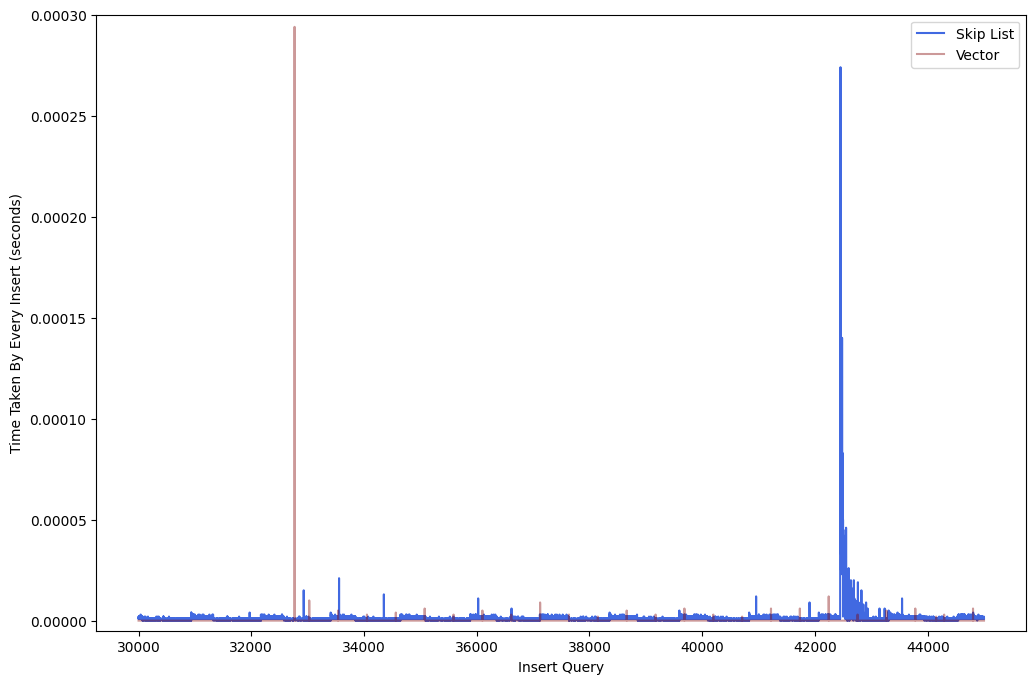

In [13]:
FIGSIZE = (12, 8)
fig, ax = plt.subplots(figsize=FIGSIZE)
# ax.plot(skip_df.index, skip_df['TimeTaken'], color='royalblue', label='Skip List')
# ax.plot(vec_df.index, vec_df['TimeTaken'], alpha=0.4, color='maroon', label='Vector')
ax.plot(skip_df.index[30000:45000], skip_df['TimeTaken'][30000:45000], color='royalblue', label='Skip List')
ax.plot(vec_df.index[30000:45000], vec_df['TimeTaken'][30000:45000], alpha=0.4, color='maroon', label='Vector')
ax.set_xlabel('Insert Query')
ax.set_ylabel('Time Taken By Every Insert (seconds)')
ax.legend()
# ax.set_ylim(bottom= -0.0001, top=0.0013)
ax.set_ylim(-0.000005, 0.00030)
# ax.set_yscale('log')

In [5]:
def get_times(log_file, key="InsertTime: "):

    result_list = list()

    for line in open(log_file, 'r').readlines():
        if line.startswith(key):
            result_list.append(int(line.split(' ')[1]))

    return result_list

In [6]:
import io

vec_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m skiplist E 64 B 64 P 4096 T 4/workload.log"
hash_skip_list_file_0_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 0 bucket_count 100000/workload.log"
hash_link_list_file_0_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 0 bucket_count 100000/workload.log"
hash_skip_list_file_10_1 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 10 bucket_count 1/workload.log"
hash_link_list_file_10_1 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 10 bucket_count 1/workload.log"
hash_skip_list_file_6_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"
hash_link_list_file_6_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"
hash_skip_list_file_2_10000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 2 bucket_count 10000/workload.log"
hash_link_list_file_2_10000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 2 bucket_count 10000/workload.log"


hash_skip_lines_0_100000 = list()
hash_link_lines_0_100000 = list()
hash_skip_lines_10_1 = list()
hash_link_lines_10_1 = list()
hash_skip_lines_6_100000 = list()
hash_link_lines_6_100000 = list()
hash_skip_lines_2_10000 = list()
hash_link_lines_2_10000 = list()

vec_lines = list()
for line in open(vec_log_file).readlines():
    if "PointQueryTime:" in line:
        vec_lines.append(line)


vec_sort_lines = list()
for line in open(vec_log_file).readlines():
    if "SortingTime: " in line:
        vec_sort_lines.append(line)


skip_lines = list()
for line in open(skip_log_file).readlines():
    if "PointQueryTime:" in line:
        skip_lines.append(line)

for line in open(hash_skip_list_file_0_100000).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_0_100000.append(line)

# hash_skip_lines_hash = list()
# for line in open(hash_skip_list_file).readlines():
#     if "PointQueryTime:" not in line:
#         hash_skip_lines_hash.append(line)

for line in open(hash_link_list_file_0_100000).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_0_100000.append(line)



for line in open(hash_skip_list_file_10_1).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_10_1.append(line)


for line in open(hash_link_list_file_10_1).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_10_1.append(line)


for line in open(hash_skip_list_file_6_100000).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_6_100000.append(line)


for line in open(hash_link_list_file_6_100000).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_6_100000.append(line)


for line in open(hash_skip_list_file_2_10000).readlines():
    if "PointQueryTime:" in line:
        hash_skip_lines_2_10000.append(line)


for line in open(hash_link_list_file_2_10000).readlines():
    if "PointQueryTime:" in line:
        hash_link_lines_2_10000.append(line)




skip_df = pd.read_csv(io.StringIO("\n".join(skip_lines)), names=['TimeTaken'])
vec_df = pd.read_csv(io.StringIO("\n".join(vec_lines)), names=['TimeTaken'])
vec_sort_time_df = pd.read_csv(io.StringIO("\n".join(vec_sort_lines)), names=['TimeTaken'])
hash_skip_df_0_100000 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_0_100000)), names=['TimeTaken'])
# hash_skip_hash_df = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_hash)), names=['TimeTaken'])

hash_skip_df_10_1 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_10_1)), names=['TimeTaken'])
hash_skip_df_6_100000 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_6_100000)), names=['TimeTaken'])
hash_skip_df_2_10000 = pd.read_csv(io.StringIO("\n".join(hash_skip_lines_2_10000)), names=['TimeTaken'])




hash_link_df_0_100000 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_0_100000)), names=['TimeTaken'])
hash_link_df_10_1 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_10_1)), names=['TimeTaken'])
hash_link_df_6_100000 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_6_100000)), names=['TimeTaken'])
hash_link_df_2_10000 = pd.read_csv(io.StringIO("\n".join(hash_link_lines_2_10000)), names=['TimeTaken'])



vec_df['TimeTaken'] = vec_df['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
vec_sort_time_df['TimeTaken'] = vec_sort_time_df['TimeTaken'].apply(lambda x: int(x.split("SortingTime: ")[1]))
skip_df['TimeTaken'] = skip_df['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
# hash_skip_hash_df['TimeTaken'] = hash_skip_hash_df['TimeTaken'].apply(lambda x: int(x.split("ComputeHashTime: ")[1]))









hash_skip_df_0_100000['TimeTaken'] = hash_skip_df_0_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_0_100000['TimeTaken'] = hash_link_df_0_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_skip_df_10_1['TimeTaken'] = hash_skip_df_10_1['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_10_1['TimeTaken'] = hash_link_df_10_1['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_skip_df_6_100000['TimeTaken'] = hash_skip_df_6_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_6_100000['TimeTaken'] = hash_link_df_6_100000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_skip_df_2_10000['TimeTaken'] = hash_skip_df_2_10000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))
hash_link_df_2_10000['TimeTaken'] = hash_link_df_2_10000['TimeTaken'].apply(lambda x: int(x.split("PointQueryTime: ")[1]))

# vec_df = vec_df.apply(lambda x : x / (10**6))
# skip_df = skip_df.apply(lambda x : x / (10**6))
# # hash_skip_hash_df = hash_skip_hash_df.apply(lambda x : x / (10**6))
# hash_skip_df_0_100000 = hash_skip_df_0_100000.apply(lambda x : x / (10**6))
# hash_link_df_0_100000 = hash_link_df_0_100000.apply(lambda x : x / (10**6))
# hash_skip_df_10_1 = hash_skip_df_10_1.apply(lambda x : x / (10**6))
# hash_link_df_10_1 = hash_link_df_10_1.apply(lambda x : x / (10**6))
# hash_skip_df_6_100000 = hash_skip_df_6_100000.apply(lambda x : x / (10**6))
# hash_link_df_6_100000 = hash_link_df_6_100000.apply(lambda x : x / (10**6))
# hash_skip_df_2_10000 = hash_skip_df_2_10000.apply(lambda x : x / (10**6))
# hash_link_df_2_10000 = hash_link_df_2_10000.apply(lambda x : x / (10**6))


In [39]:
import io

l = 6
bck = 10000
srange = 0.0001
lrange = 0.8

vec_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_log_file = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m skiplist E 64 B 64 P 4096 T 4/workload.log"
hash_skip_list_file_6_100000 = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashskiplist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"
hash_link_list_file_6_100000 = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64-LSM2/I 140000 U 0 S 0 Y 0 Q 1000 m hashlinklist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"

hash_link_list_write_6_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-IN-0-64/I 140000 U 0 S 0 Y 0 Q 0 m hashlinklist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"
hash_skip_list_write_6_100000 = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-IN-0-64/I 140000 U 0 S 0 Y 0 Q 0 m hashskiplist E 64 B 64 P 4096 T 4 l 6 bucket_count 100000/workload.log"

vec_range_log_file = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{srange}-64/I 140000 U 0 S 200 Y {srange} Q 0 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_range_log_file = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{srange}-64/I 140000 U 0 S 200 Y {srange} Q 0 m skiplist E 64 B 64 P 4096 T 4/workload.log"
hash_skip_list_range_log_file_6_100000 = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{srange}-64/I 140000 U 0 S 200 Y {srange} Q 0 m hashskiplist E 64 B 64 P 4096 T 4 l {l} bucket_count {bck}/workload.log"
hash_link_list_range_log_file_6_100000 = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{srange}-64/I 140000 U 0 S 200 Y {srange} Q 0 m hashlinklist E 64 B 64 P 4096 T 4 l {l} bucket_count {bck}/workload.log"

vec_lrange_log_file = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{lrange}-64/I 140000 U 0 S 200 Y {lrange} Q 0 m vector E 64 B 64 P 4096 T 4/workload.log"
skip_lrange_log_file = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{lrange}-64/I 140000 U 0 S 200 Y {lrange} Q 0 m skiplist E 64 B 64 P 4096 T 4/workload.log"
hash_skip_list_lrange_log_file_6_100000 = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{lrange}-64/I 140000 U 0 S 200 Y {lrange} Q 0 m hashskiplist E 64 B 64 P 4096 T 4 l {l} bucket_count {bck}/workload.log"
hash_link_list_lrange_log_file_6_100000 = f"/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-RQL-{lrange}-64/I 140000 U 0 S 200 Y {lrange} Q 0 m hashlinklist E 64 B 64 P 4096 T 4 l {l} bucket_count {bck}/workload.log"


vec_insert_time = get_times(vec_log_file, key="InsertTime: ")
skip_insert_time = get_times(skip_log_file, key="InsertTime: ")
hash_skip_insert_time = get_times(hash_skip_list_write_6_100000, key="InsertTime: ")
hash_link_insert_time = get_times(hash_link_list_write_6_100000, key="InsertTime: ")

vec_pq_time = get_times(vec_log_file, key="PointQueryTime: ")
skip_pq_time = get_times(skip_log_file, key="PointQueryTime: ")
hash_skip_pq_time = get_times(hash_skip_list_file_6_100000, key="PointQueryTime: ")
hash_link_pq_time = get_times(hash_link_list_file_6_100000, key="PointQueryTime: ")

vec_range_time = get_times(vec_range_log_file, key="RangeQueryTime: ")
skip_range_time = get_times(skip_range_log_file, key="RangeQueryTime: ")
hash_skip_range_time = get_times(hash_skip_list_range_log_file_6_100000, key="RangeQueryTime: ")
hash_link_range_time = get_times(hash_link_list_range_log_file_6_100000, key="RangeQueryTime: ")

vec_lrange_time = get_times(vec_lrange_log_file, key="RangeQueryTime: ")
skip_lrange_time = get_times(skip_lrange_log_file, key="RangeQueryTime: ")
hash_skip_lrange_time = get_times(hash_skip_list_lrange_log_file_6_100000, key="RangeQueryTime: ")
hash_link_lrange_time = get_times(hash_link_list_lrange_log_file_6_100000, key="RangeQueryTime: ")



In [40]:
avg_time_insert = {
    'Vector': sum(vec_insert_time)/len(vec_insert_time),
    'Skip': sum(skip_insert_time)/len(skip_insert_time),
    'HashSkipList': sum(hash_skip_insert_time)/len(hash_skip_insert_time),
    'HashLinkList': sum(hash_link_insert_time)/len(hash_link_insert_time)
}

In [41]:
avg_time_pq = {
    'Vector': sum(vec_pq_time)/len(vec_pq_time),
    'Skip': sum(skip_pq_time)/len(skip_pq_time),
    'HashSkipList': sum(hash_skip_pq_time)/len(hash_skip_pq_time),
    'HashLinkList': sum(hash_link_pq_time)/len(hash_link_pq_time)
}

In [42]:
avg_time_range = {
    'Vector': sum(vec_range_time)/len(vec_range_time),
    'Skip': sum(skip_range_time)/len(skip_range_time),
    'HashSkipList': sum(hash_skip_range_time)/len(hash_skip_range_time),
    'HashLinkList': sum(hash_link_range_time)/len(hash_link_range_time)
}

In [43]:
avg_time_lrange = {
    'Vector': sum(vec_lrange_time)/len(vec_lrange_time),
    'Skip': sum(skip_lrange_time)/len(skip_lrange_time),
    'HashSkipList': sum(hash_skip_lrange_time)/len(hash_skip_lrange_time),
    'HashLinkList': sum(hash_link_lrange_time)/len(hash_link_lrange_time)
}

In [44]:
def annotate_label(ax, recta, reactb, text=""):
    for rect1, rect2 in zip(recta, reactb):
        height = max(rect1.get_height(), rect2.get_height())
        ax.annotate("}" + f"{text}",
                    xy=(rect1.get_x() + rect1.get_width() / 2, height),
                    xytext=(8, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

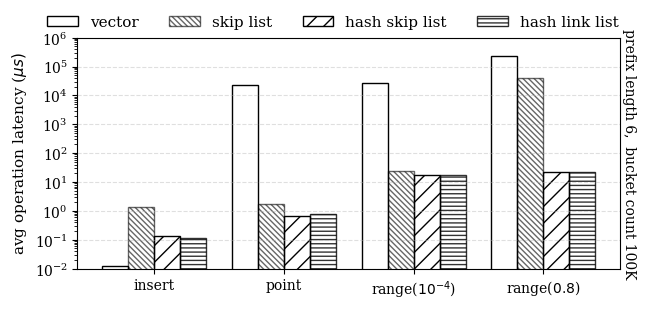

In [137]:
plt.rcParams["font.family"] = "serif"

FIGSIZE = (7, 3)


fig, ax = plt.subplots(figsize=FIGSIZE)

width = 0.2

ax.bar(
    0 - 0.3,
    avg_time_insert["Vector"],
    width,
    label="vector",
    **get_properties("Vector"),
)
ax.bar(
    0 - 0.1,
    avg_time_insert["Skip"],
    width,
    label="skip list",
    **get_properties("Skiplist"),
)
rect1 = ax.bar(
    0 + 0.1,
    avg_time_insert["HashSkipList"],
    width,
    label="hash skip list",
    **get_properties("HashSkipList"),
)
rect2 = ax.bar(
    0 + 0.3,
    avg_time_insert["HashLinkList"],
    width,
    label="hash link list",
    **get_properties("HashLinkList"),
)

# annotate_label(ax, rect1, rect2, f"  l {l}, bck {bck}")

ax.bar(
    1 - 0.3,
    avg_time_pq["Vector"],
    width,
    **get_properties("Vector"),
)
ax.bar(
    1 - 0.1,
    avg_time_pq["Skip"],
    width,
    **get_properties("Skiplist"),
)
rect3 = ax.bar(
    1 + 0.1,
    avg_time_pq["HashSkipList"],
    width,
    **get_properties("HashSkipList"),
)
rect4 = ax.bar(
    1 + 0.3,
    avg_time_pq["HashLinkList"],
    width,
    **get_properties("Hashlinklist"),
)

# annotate_label(ax, rect3, rect4, f"  l {l}, bck {bck}")

ax.bar(
    2 - 0.3,
    avg_time_range["Vector"],
    width,
    **get_properties("Vector"),
)
ax.bar(
    2 - 0.1,
    avg_time_range["Skip"],
    width,
    **get_properties("Skiplist"),
)
rect5 = ax.bar(
    2 + 0.1,
    avg_time_range["HashSkipList"],
    width,
    **get_properties("HashSkipList"),
)
rect6 = ax.bar(
    2 + 0.3,
    avg_time_range["HashLinkList"],
    width,
    **get_properties("HashLinkList"),
)

# annotate_label(ax, rect5, rect6, f"  l {l}, bck {bck}")

ax.bar(
    3 - 0.3,
    avg_time_lrange["Vector"],
    width,
    **get_properties("Vector"),
)
ax.bar(
    3 - 0.1,
    avg_time_lrange["Skip"],
    width,
    **get_properties("Skiplist"),
)
rect7 = ax.bar(
    3 + 0.1,
    avg_time_lrange["HashSkipList"],
    width,
    **get_properties("HashSkipList"),
)
rect8 = ax.bar(
    3 + 0.3,
    avg_time_lrange["HashLinkList"],
    width,
    **get_properties("HashLinkList"),
)

# annotate_label(ax, rect7, rect8, f"  l {l}, bck {bck}")

xticks = [i for i in range(4)]
ax.set_xticks(xticks)
ax.set_xticklabels(["insert", "point", r"range($10^{-4}$)", r"range($0.8$)"], fontsize=10)

ax.set_ylabel("avg operation latency (${\mu}s)$", fontsize=11)

ax.set_ylim(bottom=(10**-2), top=(10**6))
# ax.set_title(f"l {l}, bck {bck}", fontsize=11)

fig.legend(loc='upper center', ncol=4, fontsize=11, bbox_to_anchor=(0.49, 1), frameon=False)
ax.set_yscale("log")
ax.text(x=1.03, y=0.5, s='prefix length 6,  bucket count 100K', fontsize=10,
        horizontalalignment='right', 
        verticalalignment='center', 
        transform=ax.transAxes, rotation=270)
# grid = True
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()

In [230]:
df.columns

df_0_05 = df

In [20]:
avg_inserts_time_hash_skip_list = df_0_05[(df_0_05['memtable'] == 'Hashskiplist') & (df_0_05['prefixLen'] >= 0) & (df_0_05['bucketCount'] == 1000)][['AvgInsertTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])
# avg_inserts_time_hash_link_list = df_0_05[(df_0_05['memtable'] == 'Hashlinklist') & (df_0_05['prefixLen'] >= 0) & (df_0_05['bucketCount'] == 1000)][['AvgInsertTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])

avg_rq_time_hash_skip_list = df_0_05[(df_0_05['memtable'] == 'Hashskiplist') & (df_0_05['prefixLen'] >= 0) & (df_0_05['bucketCount'] == 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])
# avg_rq_time_hash_link_list = df_0_05[(df_0_05['memtable'] == 'Hashlinklist') & (df_0_05['prefixLen'] >= 0) & (df_0_05['bucketCount'] == 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])

avg_pq_time_hash_skip_list = df_pq[(df_pq['memtable'] == 'Hashskiplist') & (df_pq['prefixLen'] >= 0) & (df_pq['bucketCount'] == 1000)][['AvgPointQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])

avg_lrq_time_hash_skip_list = df_0_8[(df_0_8['memtable'] == 'Hashskiplist') & (df_0_8['prefixLen'] >= 0) & (df_0_8['bucketCount'] == 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])
avg_lrq_time_hash_link_list = df_0_8[(df_0_8['memtable'] == 'Hashlinklist') & (df_0_8['prefixLen'] >= 0) & (df_0_8['bucketCount'] == 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['prefixLen', 'bucketCount'])

NameError: name 'df_0_05' is not defined

In [233]:
avg_rq_time_hash_skip_list

,AvgRangeQueryTime,prefixLen,bucketCount
1,40624.875,0,1000
0,970.945,2,1000
4,125.860,6,1000
2,122.845,10,1000
3,122.285,12,1000


In [138]:
avg_lrq_time_hash_skip_list

,AvgRangeQueryTime,prefixLen,bucketCount
1,40624.875,0,1000
0,970.945,2,1000
4,125.860,6,1000
2,122.845,10,1000
3,122.285,12,1000


findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not fo

findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial

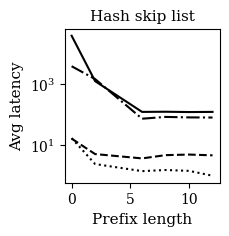

In [295]:
FIGSIZE = (2, 2)

fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(avg_inserts_time_hash_skip_list['prefixLen'], avg_inserts_time_hash_skip_list['AvgInsertTime'], linestyle='--', color='black', label="inserts")
ax.plot(avg_pq_time_hash_skip_list['prefixLen'], avg_pq_time_hash_skip_list['AvgPointQueryTime'], linestyle=':', color='black', label="Point queries")
ax.plot(avg_rq_time_hash_skip_list['prefixLen'], avg_rq_time_hash_skip_list['AvgRangeQueryTime'], linestyle='-.', color='black', label="range queries (S)")
ax.plot(avg_lrq_time_hash_skip_list['prefixLen'], avg_lrq_time_hash_skip_list['AvgRangeQueryTime'], linestyle='-', color='black', label="range queries (L)")

ax.set_title('Hash skip list', fontsize=11)
ax.set_xlabel('Prefix length', fontsize=11)
ax.set_ylabel('Avg latency', fontsize=11)

ax.set_yscale('log')

# ax.legend()

In [298]:
avg_inserts_time_hash_skip_list = df_0_05[(df_0_05['memtable'] == 'Hashskiplist') & (df_0_05['prefixLen'] == 6) & (df_0_05['bucketCount'] >= 1000)][['AvgInsertTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])
# avg_inserts_time_hash_link_list = df_0_05[(df_0_05['memtable'] == 'Hashlinklist') & (df_0_05['prefixLen'] == 6) & (df_0_05['bucketCount'] >= 1000)][['AvgInsertTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])

avg_rq_time_hash_skip_list = df_0_05[(df_0_05['memtable'] == 'Hashskiplist') & (df_0_05['prefixLen'] == 6) & (df_0_05['bucketCount'] >= 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])
# avg_rq_time_hash_link_list = df_0_05[(df_0_05['memtable'] == 'Hashlinklist') & (df_0_05['prefixLen'] == 6) & (df_0_05['bucketCount'] >= 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])

avg_pq_time_hash_skip_list = df_pq[(df_pq['memtable'] == 'Hashskiplist') & (df_pq['prefixLen'] == 6) & (df_pq['bucketCount'] >= 1000) & (df_pq['bucketCount'] < 100000) ][['AvgPointQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])

avg_lrq_time_hash_skip_list = df_0_8[(df_0_8['memtable'] == 'Hashskiplist') & (df_0_8['prefixLen'] == 6) & (df_0_8['bucketCount'] >= 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])
# avg_lrq_time_hash_link_list = df_0_8[(df_0_8['memtable'] == 'Hashlinklist') & (df_0_8['prefixLen'] == 6) & (df_0_8['bucketCount'] >= 1000)][['AvgRangeQueryTime', 'prefixLen', 'bucketCount']].sort_values(by=['bucketCount', 'prefixLen'])

In [272]:
avg_inserts_time_hash_skip_list

,AvgInsertTime,prefixLen,bucketCount
1,3.598503,6,1000
3,4.431440,6,5000
30,4.360355,6,8000
9,4.263220,6,10000


In [273]:
avg_rq_time_hash_skip_list

,AvgRangeQueryTime,prefixLen,bucketCount
1,73.560,6,1000
3,25.700,6,5000
30,19.415,6,8000
9,19.590,6,10000


In [274]:
avg_lrq_time_hash_skip_list

,AvgRangeQueryTime,prefixLen,bucketCount
66,123.380,6,1000
70,33.855,6,5000
54,24.700,6,8000
32,22.955,6,10000


In [280]:
avg_pq_time_hash_skip_list

,AvgPointQueryTime,prefixLen,bucketCount
66,1.366,6,1000
37,1.127,6,5000
68,1.150,6,8000
76,1.016,6,10000


findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not fo

findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not fo

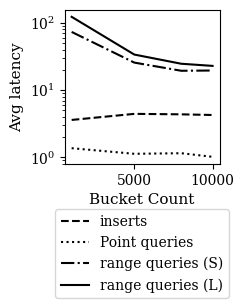

In [306]:
FIGSIZE = (2, 2)

fig, ax1 = plt.subplots(figsize=FIGSIZE)

ax1.plot(avg_inserts_time_hash_skip_list['bucketCount'], avg_inserts_time_hash_skip_list['AvgInsertTime'], linestyle='--', color='black', label="inserts")
ax1.plot(avg_pq_time_hash_skip_list['bucketCount'], avg_pq_time_hash_skip_list['AvgPointQueryTime'], linestyle=':', color='black', label="Point queries")
ax1.plot(avg_rq_time_hash_skip_list['bucketCount'], avg_rq_time_hash_skip_list['AvgRangeQueryTime'], linestyle='-.', color='black', label="range queries (S)")
ax1.plot(avg_lrq_time_hash_skip_list['bucketCount'], avg_lrq_time_hash_skip_list['AvgRangeQueryTime'], linestyle='-', color='black', label="range queries (L)")

# ax1.set_title('Hash skip list', fontsize=11)
ax1.set_xlabel('Bucket Count', fontsize=11)
ax1.set_ylabel('Avg latency', fontsize=11)

ax1.set_yscale('log')

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          ncol=1)

In [107]:
skip_df.mean()

TimeTaken    2.189
dtype: float64

In [16]:
hash_skip_df_0_100000.mean()

TimeTaken    17.593
dtype: float64

In [17]:
hash_link_df_0_100000.mean()

TimeTaken    929.071
dtype: float64

In [18]:
vec_sort_time_df

,TimeTaken
0,11897
1,0
2,6939
3,0
4,5690
...,...
141998,0
141999,0
142000,0
142001,0


findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not fo

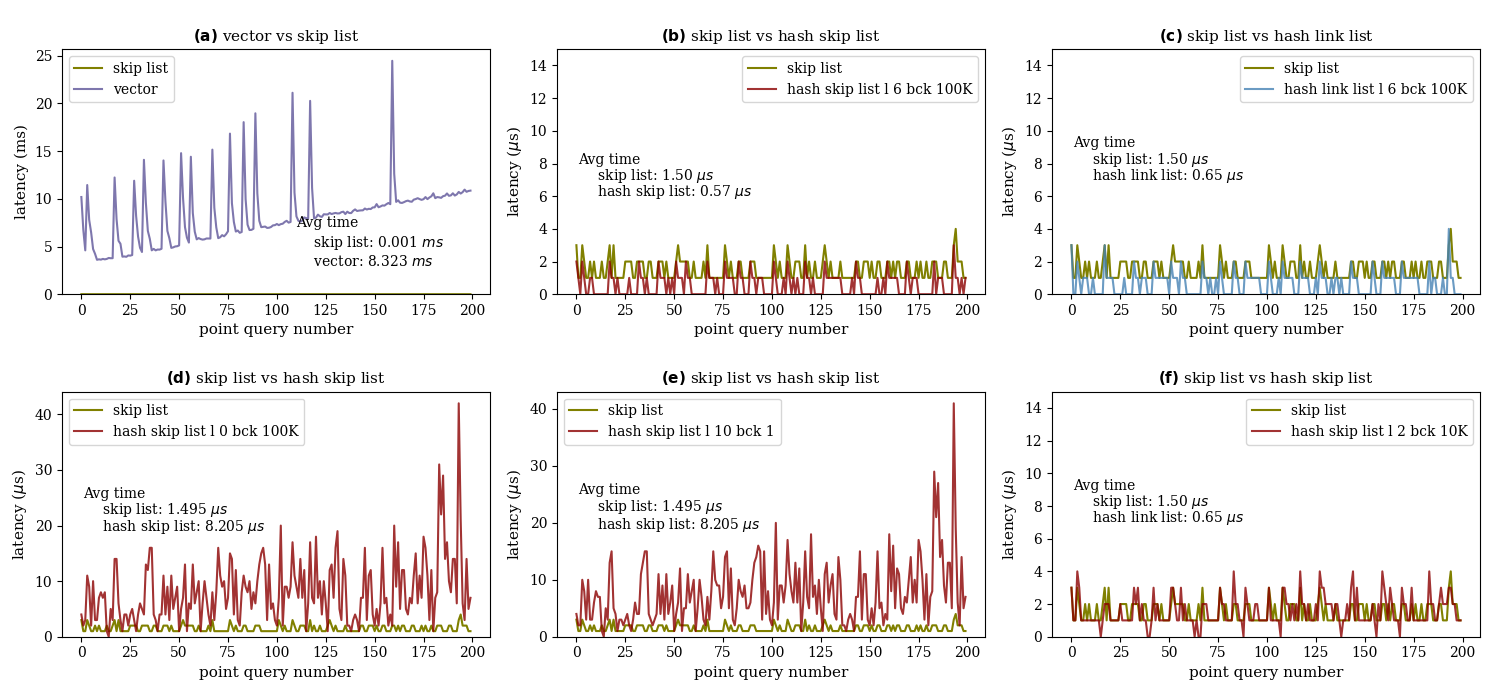

In [24]:
plt.rcParams["font.family"] = "Arial", "Gulasch", "Times", "Times New Roman", "serif"

num = 200

FIGSIZE = (15, 7)
fig, ax = plt.subplots(2, 3, figsize=FIGSIZE)
ax[0,0].plot(skip_df.index[:num], skip_df['TimeTaken'][:num] / (1000), color='olive', label='skip list')
# ax.plot(vec_sort_time_df.index[:num][:1001], vec_sort_time_df['TimeTaken'][:num][:2001:2].apply(lambda x: x-1000), label='Vector Sort Time')
ax[0,0].plot(vec_df.index[:num], vec_df['TimeTaken'][:num]/(1000), alpha=0.7, color='darkslateblue', label='vector')

ax[0,0].set_title("\n$\mathbf{{(a)}}$ vector vs skip list", fontsize=11)
ax[0,0].set_xlabel('point query number', fontsize=11)
ax[0,0].set_ylabel('latency (ms)', fontsize=11)
ax[0,0].set_ylim(bottom=0)
ax[0,0].legend()
ax[0,0].annotate(f"Avg time", xy=(110,7))
ax[0,0].annotate(f"    skip list: {(skip_df[:num] / 1000).mean()['TimeTaken']:.3f} $\mathit{{ms}}$", xy=(110,5))
ax[0,0].annotate(f"    vector: {(vec_df[:num] / 1000).mean()['TimeTaken']:.3f} $\mathit{{ms}}$", xy=(110,3))



# ax.plot(hash_link_df_0_100000.index[:num], hash_link_df_0_100000['TimeTaken'][:num], alpha=0.4, label='hash Link List l 0 bck 100000')
# ax.plot(hash_link_df_10_1.index[:num], hash_link_df_10_1['TimeTaken'][:num], alpha=0.4, label='hash Link List l 10 bck 1')
# ax.plot(hash_skip_df_6_100000.index[:num], hash_skip_df_6_100000['TimeTaken'][:num], alpha=0.4, label='hash skip List l 6 bck 100000')
# ax.plot(hash_link_df_6_100000.index[:num], hash_link_df_6_100000['TimeTaken'][:num], alpha=0.4, label='hash Link List l 6 bck 100000')
# ax.plot(hash_link_df_2_10000.index[:num], hash_link_df_2_10000['TimeTaken'][:num], alpha=0.4, label='hash Link List l 2 bck 10000')


ax[0,1].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], color='olive', label='skip list')
ax[0,1].plot(hash_skip_df_6_100000.index[:num], hash_skip_df_6_100000['TimeTaken'][:num], alpha=0.8, color='darkred', label='hash skip list l 6 bck 100K')

ax[0,1].set_title("\n$\mathbf{{(b)}}$ skip list vs hash skip list", fontsize=11)
ax[0,1].set_xlabel(f'point query number', fontsize=11)
ax[0,1].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[0,1].set_ylim(bottom=0, top=15)
ax[0,1].legend()
ax[0,1].annotate(f"Avg time", xy=(1,8))
ax[0,1].annotate(f"    skip list: {skip_df[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,7))
ax[0,1].annotate(f"    hash skip list: {hash_skip_df_6_100000[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,6))





ax[0,2].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], color='olive', label='skip list')
ax[0,2].plot(hash_link_df_6_100000.index[:num], hash_link_df_6_100000['TimeTaken'][:num], alpha=0.8, color='steelblue', label='hash link list l 6 bck 100K')

ax[0,2].set_title("\n$\mathbf{{(c)}}$ skip list vs hash link list", fontsize=11)
ax[0,2].set_xlabel('point query number', fontsize=11)
ax[0,2].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[0,2].set_ylim(bottom=0, top=15)
ax[0,2].legend()
ax[0,2].annotate(f"Avg time", xy=(1,9))
ax[0,2].annotate(f"    skip list: {skip_df[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,8))
ax[0,2].annotate(f"    hash link list: {hash_link_df_6_100000[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,7))


# ax.set_ylim(bottom= -0.0001, top=0.0013)
# ax[0].set_xlim(left=0, right=1000)

# ax[1].set_xlim(left=0, right=1000)
# ax[1].set_yscale('log')

ax[1,0].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], color='olive', label='skip list')
ax[1,0].plot(hash_skip_df_0_100000.index[:num], hash_skip_df_0_100000['TimeTaken'][:num], alpha=0.8, color='darkred', label='hash skip list l 0 bck 100K')

ax[1,0].set_title("\n$\mathbf{{(d)}}$ skip list vs hash skip list", fontsize=11)
ax[1,0].set_xlabel('point query number', fontsize=11)
ax[1,0].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[1,0].set_ylim(bottom=0)
ax[1,0].legend()
ax[1,0].annotate(f"Avg time", xy=(1,25))
ax[1,0].annotate(f"    skip list: {(skip_df[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,22))
ax[1,0].annotate(f"    hash skip list: {(hash_skip_df_0_100000[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,19))

ax[1,1].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], color='olive', label='skip list')
ax[1,1].plot(hash_skip_df_10_1.index[:num], hash_skip_df_10_1['TimeTaken'][:num], alpha=0.8, color='darkred', label='hash skip list l 10 bck 1')

ax[1,1].set_title("\n$\mathbf{{(e)}}$ skip list vs hash skip list", fontsize=11)
ax[1,1].set_xlabel(f'point query number', fontsize=11)
ax[1,1].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[1,1].set_ylim(bottom=0)
ax[1,1].legend()
ax[1,1].annotate(f"Avg time", xy=(1,25))
ax[1,1].annotate(f"    skip list: {(skip_df[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,22))
ax[1,1].annotate(f"    hash skip list: {(hash_skip_df_0_100000[:num]).mean()['TimeTaken']:.3f} $\mathit{{\mu}}s$", xy=(2,19))



ax[1,2].plot(skip_df.index[:num], skip_df['TimeTaken'][:num], color='olive', label='skip list')
ax[1,2].plot(hash_skip_df_2_10000.index[:num], hash_skip_df_2_10000['TimeTaken'][:num], alpha=0.8, color='darkred', label='hash skip list l 2 bck 10K')

ax[1,2].set_title("\n$\mathbf{{(f)}}$ skip list vs hash skip list", fontsize=11)
ax[1,2].set_xlabel('point query number', fontsize=11)
ax[1,2].set_ylabel('latency ($\mu$s)', fontsize=11)
ax[1,2].set_ylim(bottom=0, top=15)
ax[1,2].legend()
ax[1,2].annotate(f"Avg time", xy=(1,9))
ax[1,2].annotate(f"    skip list: {skip_df[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,8))
ax[1,2].annotate(f"    hash link list: {hash_link_df_6_100000[:num].mean()['TimeTaken']:.2f} $\mathit{{\mu}}s$", xy=(2,7))
# ax[1,2].plot(hash_skip_df_10_1.index[:num], hash_skip_df_10_1['TimeTaken'][:num], alpha=0.8, color='darkred', label='hash skip List l 10 bck 1')

plt.tight_layout()


In [20]:
workload_txt = "/home/cc/LSMMemoryProfiling/development/rocksdb/examples/__working_branch/experiments-PQ-64/workload.txt"

inserts = list()

for line in open(workload_txt, 'r'):
    if line.startswith("I "):
        inserts.append(line.split(' ')[1])

prefix_len = 2

prefix_set = set([ins[:prefix_len] for ins in inserts])

In [21]:
prefix_specific_keys_count = dict()

for k in inserts:
    pref = k[:prefix_len]

    if pref in prefix_specific_keys_count.keys():
        prefix_specific_keys_count[pref] += 1
    else:
        prefix_specific_keys_count[pref] = 1

In [22]:
pqs = list()

i = 0
for line in open(workload_txt, 'r'):
    if line.startswith("Q "):
        pqs.append(i)
        i = 0
    else:
        i += 1

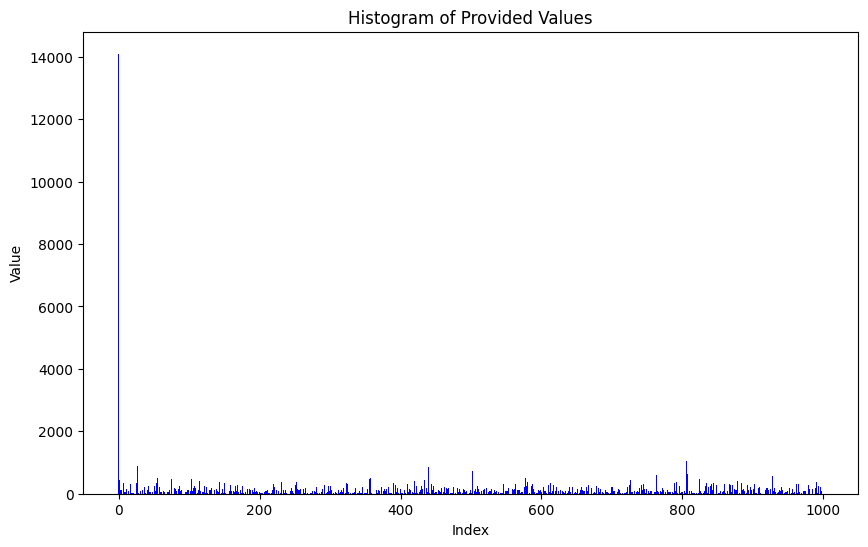

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(pqs)), pqs, color='blue')
plt.title('Histogram of Provided Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

(array([117.,  92.,  88.,  63.,  57.,  70.,  56.,  43.,  45.,  34.,  42.,
         31.,  30.,  28.,  12.,  22.,  16.,  21.,  16.,  14.,  10.,  18.,
          5.,  14.,   6.,   4.,   2.,   5.,   5.,   1.,   2.,   1.,   4.,
          2.,   0.,   1.,   3.,   0.,   0.,   4.,   3.,   0.,   0.,   1.,
          2.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

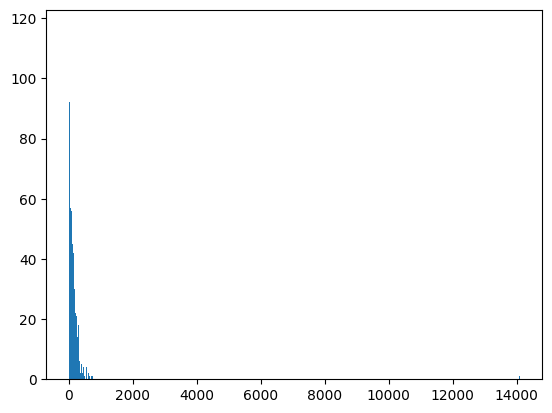

In [24]:
plt.hist(pqs, bins=1000)

findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Gulasch' not found.
findfont: Font family 'Times' not fo

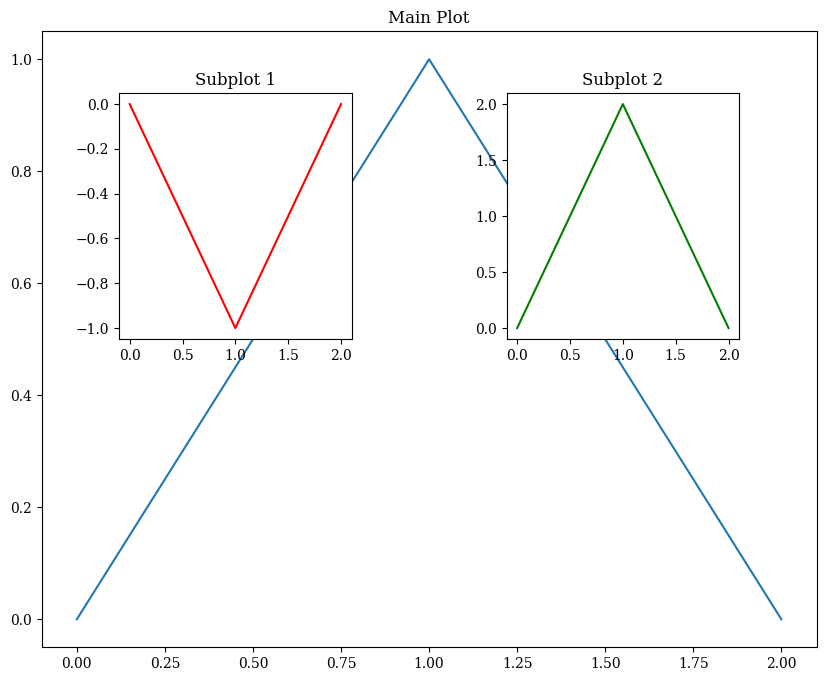

In [127]:
import matplotlib.pyplot as plt

# Create the main figure and top level subplot
fig, main_ax = plt.subplots(figsize=(10, 8))

# Add a smaller subplot within the main subplot
# The list argument of add_axes() represents the dimensions [left, bottom, width, height] in figure coordinate system, which range from 0 to 1
sub_ax1 = main_ax.inset_axes([0.1, 0.5, 0.3, 0.4])  # Example: x position, y position, width, height
sub_ax2 = main_ax.inset_axes([0.6, 0.5, 0.3, 0.4])  # Adjust these values to position your subplots

# Plot on the main axis
main_ax.plot([0, 1, 2], [0, 1, 0], label='Main plot')
main_ax.set_title('Main Plot')

# Plot on the first smaller axis
sub_ax1.plot([0, 1, 2], [0, -1, 0], label='Subplot 1', color='r')
sub_ax1.set_title('Subplot 1')

# Plot on the second smaller axis
sub_ax2.plot([0, 1, 2], [0, 2, 0], label='Subplot 2', color='g')
sub_ax2.set_title('Subplot 2')

# Display the plot
plt.show()
